## RedHat Kaggle

https://www.kaggle.com/c/predicting-red-hat-business-value

##### Load libraries

In [1]:
# pandas
import pandas as pd

# scipy 
import scipy as sp
from scipy.sparse import csr_matrix

# numpy
import numpy as np

# sklearn models 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import tree

# scoring and cross validation 
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, r2_score
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import validation_curve

# multiprocessing
import multiprocessing
CPUS = multiprocessing.cpu_count()

# collections 
from collections import Counter, defaultdict
from copy import copy

# hashing
import hashlib

# regular expressions 
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pickle
import pickle

# logging 
import logging
logging.basicConfig()

In [2]:
logging.warn('Num CPUs: {}'.format(CPUS))

In [3]:
DIR = './'
FTRAIN = 'Data/act_train.csv.gz'
FTEST = 'Data/act_test.csv.gz'
FPEOPLE = 'Data/people.csv.gz'
FSAMPLE = 'Data/sample_submission.csv.gz'
SPARSE_TRAIN_FILE = DIR+'Data/sparse_train.dat'
SPARSE_TEST_FILE = DIR+'Data/sparse_test.dat'
ID_FILE = DIR+'Data/ids.dat'
Y_FILE = DIR+'Data/y.dat'

##### Custom Functions

In [4]:
def format_col(x, p):
    if type(x)==str:
        return p+'_'+x.replace(' ','_')
    else:
        return p+'_'+str(x)

def update_cols(df,c=1):
    # fix date columns
    df['date'] = pd.to_datetime(df['date'])
    
    # split date column into several 
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['qtr'] = df['date'].dt.month // 3
    
    # remove date 
    del df['date']
    
    # get list of columns
    cols = list(df.columns)
    
    # include column name with value
    for p in cols[c:]:
        df.loc[:,p] = df.loc[:,p].apply(lambda x: format_col(x, p) )
    
    return df

In [5]:
def test_scores(y_test, predictions, pr=True):
    ll = log_loss(y_test, predictions)
    a = accuracy_score(y_test, np.argmax(predictions,axis=1))
    auc = roc_auc_score(np.c_[y_test==0, y_test==1], predictions)
    r = {'logloss':ll,'accuracy':a,'AUC':auc}
    pstr = '''Log-Loss:{logloss:.7f} Accuracy:{accuracy:.7f} AUC:{AUC:.7f}'''
    if pr: print pstr.format(**r)
    return r

RMSE = lambda x,y: np.sqrt(np.mean(x-y)**2)

In [6]:
def create_sparse_ohe_data(df, ohe_dict):
    rows = []
    cols = []
    data = []
    for i in xrange(df.shape[0]):
        s = map(lambda x: ohe_dict.get(x,-1), df.iloc[i])
        while True:
            if -1 in s:
                indval = s.index(-1)
                del s[indval]
            else:
                break
        rows += [i]*len(s)
        cols += s
        data += [1]*len(s)
    return csr_matrix((np.array(data),
                (np.array(rows),
                 np.array(cols))),
               shape=(df.shape[0],len(ohe_dict)))

In [7]:
def create_sparse_hash_data(df, num_buckets):
    rows = []
    cols = []
    data = []
    for i in xrange(df.shape[0]):
        mapping = {}
        for f in df.iloc[i]:
            mapping[f] = int(int(hashlib.md5(f).hexdigest(), 16) % num_buckets)
        s = defaultdict(float)
        for bucket in mapping.values():
            s[bucket] += 1.0
        rows += [i]*len(s)
        cols += s.keys()
        data += s.values()
    return csr_matrix((np.array(data),
                (np.array(rows),
                 np.array(cols))),
               shape=(df.shape[0],num_buckets))

In [8]:
class ClusterLogisticRegression(LogisticRegression):
    def __init__(self, n_clusters=10, n_jobs=1, C=1.0, models=[], **params):
        self.models = [ LogisticRegression(n_jobs=n_jobs, C=C, **params) 
                           for i in range(n_clusters) ] if not models else models
        self.cluster_model = KMeans(n_clusters=n_clusters, n_jobs=n_jobs)
        self.classes = 2
        self.C = C
        self.n_clusters = n_clusters
        self.n_jobs = n_jobs
    
    def set_params(self, **params):
        for i in range(self.n_clusters):
            self.models[i].set_params(**params)
    
    def fit(self, X, y):
        self.cluster_model.fit(X)
        clusters = self.cluster_model.labels_
        for i in xrange(self.n_clusters):
            self.models[i] = self.models[i].fit(X[clusters==i], 
                                                y[clusters==i])
        return self
    
    def predict_proba(self, X):
        clusters = self.cluster_model.predict(X)
        predictions = np.zeros((X.shape[0], self.classes))
        for i in xrange(self.n_clusters):
            if np.sum(clusters==i)>0:
                predictions[clusters==i,:] = self.models[i].predict_proba(X[clusters==i])[:,:]
        return predictions
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [9]:
def lr_validation_curve(X, y, 
                        param_range= np.logspace(-3, 3, 3), 
                        max_iter=100, 
                        tol=1e-4, 
                        cv=5, 
                        n_clusters=4,
                        n_jobs=CPUS):
    lr_model = ClusterLogisticRegression(max_iter=max_iter, tol=tol, n_clusters=n_clusters)
    train_scores, test_scores = validation_curve(lr_model, X, y, 
                                param_name="C", param_range=param_range,
                                cv=cv, scoring="roc_auc", n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Logistic Regression")
    plt.xlabel("C")
    plt.ylabel("AUC")
    plt.ylim(0.5, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

In [10]:
def dump_files(X, X_test, Y, IDS):
    with open(SPARSE_TRAIN_FILE, 'wb') as w:
        pickle.dump(X, w)

    with open(SPARSE_TEST_FILE, 'wb') as w:
        pickle.dump(X_test, w)

    with open(ID_FILE, 'wb') as w:
        pickle.dump(IDS, w)
    
    with open(Y_FILE, 'wb') as w:
        pickle.dump(Y, w)

def read_files():
    global X
    global X_test
    global IDs
    global Y
    
    with open(SPARSE_TRAIN_FILE, 'rb') as w:
        X = pickle.load(w)

    with open(SPARSE_TEST_FILE, 'rb') as w:
        X_test = pickle.load(w)

    with open(ID_FILE, 'rb') as w:
        IDs = pickle.load(w) 
    
    with open(Y_FILE, 'rb') as w:
        Y = pickle.load(w)

def check_exists(x_str):
    x_exists = x_str in locals() or x_str in globals()
    return x_exists

##### Load data

In [11]:
train_raw = pd.read_csv(DIR+FTRAIN)
test_raw = pd.read_csv(DIR+FTEST)
people = pd.read_csv(DIR+FPEOPLE)

In [26]:
train_raw.shape

(2197291, 15)

In [27]:
test_raw.shape

(498687, 14)

In [28]:
people.shape

(189118, 41)

#### Set date types

In [29]:
train_raw['date'] = pd.to_datetime(train_raw['date'])
test_raw['date'] = pd.to_datetime(test_raw['date'])

##### Activity history reference file

In [30]:
train_raw['activity_category'].value_counts()

type 2    904683
type 5    490710
type 3    429408
type 4    207465
type 1    157615
type 6      4253
type 7      3157
Name: activity_category, dtype: int64

def gather_activity_history(values):
    for v in values:
        yield train_raw.groupby(level=0)['activity_category'].apply(lambda x: np.max(x==v))

values = set( train_raw['activity_category'].values )
histories = gather_activity_history( values )
activity_history = pd.concat( histories, axis=1 )
activity_history.columns = values

In [31]:
# gather minimum dates for each person-category
r = train_raw[['people_id',
               'date',
               'activity_category']].groupby(['people_id',
                                              'activity_category']
                                            ).apply(lambda x: np.min(x.date))
r = r.reset_index()
r.columns = ['people_id','activity_category','min_date']

# merge with df data
t = train_raw.loc[:,['people_id','activity_category','date']]
tm = pd.merge(t, r, on=['people_id','activity_category'], how='outer')

# create column for each category type 
def gather_history_cols(values):
    for v in sorted(values):
        check_func = lambda x: np.max((x.activity_category==v)&(x.date>=x.min_date))
        yield tm.groupby(['people_id','date']).apply(check_func)
values = set( train_raw.activity_category.values )
activity_history = pd.concat(gather_history_cols(values), axis=1)*1
activity_history.columns = map(lambda x: 'h'+str(x),range(len(list(values))))
activity_history = activity_history.reset_index()

##### Date probability reference file

In [32]:
date_probs = train_raw.groupby('date')['outcome'].apply(np.mean)
date_probs.columns = ['date_prob']

##### Outcome variable

In [21]:
Y = train_raw['outcome']
del train_raw['outcome']

##### Make numeric features categorical

In [39]:
percentile_ref = people['char_38'].ravel()
compare_percentile = lambda x: round(sp.stats.percentileofscore(percentile_ref, x, kind='weak'),-1)
people['char_38'] = people['char_38'].apply(compare_percentile)

##### Add date probability columns

In [40]:
percentile_ref = date_probs.ravel()
compare_percentile = lambda x: round(sp.stats.percentileofscore(percentile_ref, x, kind='weak'),-1)
date_probs_df = pd.DataFrame()
date_probs_df['date_prob_pctl'] = date_probs.apply(compare_percentile)
date_probs_df = date_probs_df.reset_index()
date_probs_df['date'] = pd.to_datetime(date_probs_df['date'])

In [41]:
def add_date_probs(df, date_probs):
    df = pd.merge(df, date_probs, 
                  how='left', on='date')
    return df

train_raw = add_date_probs(train_raw, date_probs_df)
test_raw = add_date_probs(test_raw, date_probs_df)

##### Add activity history columns

In [42]:
def add_history_cols(df, activity_history):
    df = pd.merge(df, activity_history,
                 how='left', on=['people_id','date'])
    return df

train_raw = add_history_cols(train_raw, activity_history)
test_raw = add_history_cols(test_raw, activity_history)

#### Reindex and clear memory

In [43]:
train_raw.index = train_raw['people_id']
test_raw.index = test_raw['people_id']
people.index = people['people_id']
del train_raw['people_id']
del test_raw['people_id']
del people['people_id']

##### Feature engineering

In [44]:
# updated people cols
people = update_cols(people, 0)

# train features
train_raw = update_cols(train_raw, 1)

# test features
test_raw = update_cols(test_raw, 1)

##### Transform data to sparse OHE matrix

In [45]:
train_full = pd.merge(train_raw, people, left_index=True, right_index=True)
test_full = pd.merge(test_raw, people, left_index=True, right_index=True)
train_full.index = train_full['activity_id']
test_full.index = test_full['activity_id']
del train_full['activity_id']
del test_full['activity_id']

In [46]:
sum(train_full.memory_usage())*1.0/1024**3

1.1296054646372795

In [47]:
sum(test_full.memory_usage())*1.0/1024**3

0.25637003034353256

##### Create OHE dictionary 

In [48]:
all_values = np.unique(train_full.as_matrix().reshape(1,-1).ravel())
ohe_dict= { k: v for k,v in zip(all_values, xrange(all_values.shape[0])) }

In [49]:
len(ohe_dict)

36809

##### Create sparse matrices for test and training datasets

In [50]:
X = create_sparse_ohe_data(train_full, ohe_dict)

In [51]:
X_test = create_sparse_ohe_data(test_full, ohe_dict)

In [ ]:
IDs = np.array(test_full.index)

In [53]:
X.shape

(2197291, 36809)

##### Clear unused memory

In [54]:
del train_full 
del train_raw
del test_full
del test_raw
del people 
del ohe_dict
del all_values

#### Write to file

In [22]:
dump_files(X, X_test, Y, IDs)

#### Check data

In [89]:
if not check_exists('X') or check_exists('Y'):
    read_files()

## Baseline model
Use frequency of outcome variable for prediction. 

In [13]:
p = Y.value_counts()*1.0 / X.shape[0]

N = X.shape[0]
predictions = np.zeros((N,2))
for i in xrange(N):
    predictions[i,:] = p

a = accuracy_score(Y, np.argmax(predictions,axis=1))
ll = log_loss(Y, predictions)
auc = roc_auc_score(np.c_[Y==0,Y==1], predictions)
print 'Log-loss: {ll} Accuracy: {acc} AUC:{auc}'.format(acc=a,ll=ll,auc=auc)

Log-loss: 0.686851739242 Accuracy: 0.556045603427 AUC:0.5


## Naive Bayes
Would expect improvement from the baseline model.

In [ ]:
from sklearn.naive_bayes import BernoulliNB

# split test and train
N = X.shape[0]
e = N/10*8
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = X[:e,:], X[e:,:], Y[:e], Y[e:]

# train model 
nb = BernoulliNB(alpha=1e-12, binarize=0.0)
nb.fit(X_train, y_train)

# make predictions 
predictions = nb.predict_proba(X_val)
_ = test_scores(y_val, predictions)

## Logistic Regression

#### Check model parameter tuning
Using a sample of data to limit runtime.  
Assumes that sampled validation curve will match full dataset.

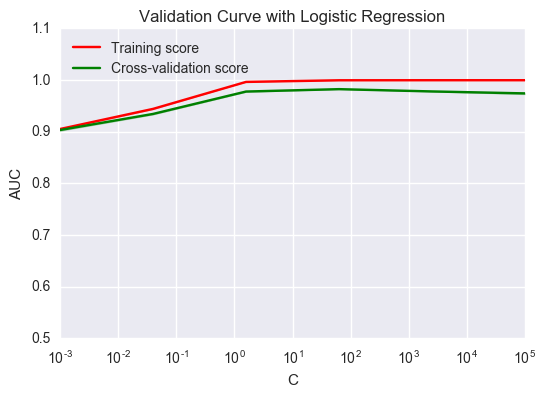

In [15]:
run_charts = True
if run_charts:
    sample = np.random.choice(xrange(X.shape[0]),size=100000)
    lr_validation_curve(X[sample,:], 
                        Y.iloc[sample], 
                        param_range= np.logspace(-3, 5, 6), 
                        n_clusters=6,
                        n_jobs=6)

## SVM 

In [107]:
from sklearn.svm import LinearSVC, SVC

In [111]:
svc = LinearSVC(C=1.0).fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [112]:
a = np.sum(svc.predict(X_val) == y_val)*1.0 / y_val.shape[0]
print 'Raw Accuracy: {}'.format(a)

Raw Accuracy: 0.910062144591


In [113]:
prob_pos = svc.decision_function(X_val)
prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
predictions = np.zeros((X_val.shape[0],2))
predictions[:,1] = prob_pos
predictions[:,0] = 1-prob_pos

In [ ]:
_ = test_scores(y_val, predictions)

Log-Loss:0.4028613 Accuracy:0.8811994 AUC:0.9774213


In [ ]:
# time is quadratic... 
svc = SVC(C=1.0, kernel='linear').fit(X_train, y_train)

## XGBoost

In [228]:
import xgboost as xgb

In [229]:
def test_scores_xgb(y_val, predictions):
    pfull = np.c_[1-predictions,predictions]
    ll = log_loss(y_val, pfull)
    a = accuracy_score(y_val, np.argmax(pfull ,axis=1))
    auc = roc_auc_score(np.c_[y_val==0, y_val==1], pfull)
    r = {'logloss':ll,'accuracy':a,'AUC':auc}
    return r

In [230]:
dtrain = xgb.DMatrix( X_train, label=y_train.as_matrix() )
dval = xgb.DMatrix( X_val, label=y_val.as_matrix() )
dtest = xgb.DMatrix( X_test )

#### Train model

In [253]:
d = 10
e = 0.05
param = {'max_depth':d, 
         'eta':e, 
         'subsample':1.0, 
         'colsample_bytree':0.25,
         'silent':1, 
         'lambda':1.0,
         'objective':'binary:logistic',
#          'min_child_weight':0,
#          'booster':'gblinear'
        }
param['eval_metric'] = 'auc'
param['nthread'] = CPUS
evallist  = [(dval,'eval'), (dtrain,'train')]
xgb_model = xgb.train(param.items(), dtrain, 1001, evallist, verbose_eval=100)

[0]	eval-auc:0.887251	train-auc:0.907409
[100]	eval-auc:0.927041	train-auc:0.956779
[200]	eval-auc:0.930713	train-auc:0.963219
[300]	eval-auc:0.932477	train-auc:0.966099
[400]	eval-auc:0.933792	train-auc:0.968184
[500]	eval-auc:0.935038	train-auc:0.97021
[600]	eval-auc:0.936014	train-auc:0.971785
[700]	eval-auc:0.936793	train-auc:0.973202
[800]	eval-auc:0.937444	train-auc:0.974321
[900]	eval-auc:0.938199	train-auc:0.975452
[1000]	eval-auc:0.938801	train-auc:0.976473


In [252]:
predictions = xgb_model.predict( dval )
test_scores_xgb(y_val, predictions)

{'AUC': 0.92570479398744743,
 'accuracy': 0.86611037662216495,
 'logloss': 0.30554118624534171}

## Logistic Regression

#### Split train and val 

In [90]:
N = X.shape[0]
e = N/10*8
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = X[:e,:], X[e:,:], Y[:e], Y[e:]

#### Run Model

In [86]:
c = 1e2
lr = LogisticRegression(C=c, max_iter=200, tol=1e-4, n_jobs=CPUS)
lr.fit(X_train, y_train)
predictions = lr.predict_proba(X_val)

In [78]:
_ = test_scores(y_val, predictions)

Log-Loss:0.2037239 Accuracy:0.9085717 AUC:0.9770336


<h3>Logistic Regression Result Tracker</h3>
<table align="left">
<tr>
    <th>Iter</th>
    <th>C</th>
    <th>Clusters</th>
    <th>Tol</th>
    <th>+Features</th>
    <th>AUC</th>
    <th>Log Loss</th>
    <th>Accuracy</th>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td></td>
    <td>0.9767696</td>
    <td>0.2064201</td>
    <td>0.9075454</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td>+Activity history</td>
    <td>0.9767806</td>
    <td>0.2046148</td>
    <td>0.9075249</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td>+Date Prob</td>
    <td>0.9768128</td>
    <td>0.2063661</td>
    <td>0.9080028</td>
</tr>
<tr>
    <td>300</td>
    <td>100</td>
    <td>1</td>
    <td>1e-5</td>
    <td>+More accurate history</td>
    <td>0.9768163</td>
    <td>0.2062309</td>
    <td>0.9082030</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-4</td>
    <td>-Iterations and tol</td>
    <td>0.9770576</td>
    <td>0.2029024</td>
    <td>0.9088720</td>
</tr>
<tr>
    <td>200</td>
    <td>100</td>
    <td>1</td>
    <td>1e-3</td>
    <td>-more tol</td>
    <td>0.9766761</td>
    <td>0.1920801</td>
    <td>0.9106515</td>
</tr>

</table>

In [84]:
# to filter out non-useful coefficients
F = (0.15*lr.coef_.shape[1])
A = np.argsort(np.abs(lr.coef_))[:,::-1].ravel()[:-F]
# X = X[:,A]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


#### Analyze residuals
Goal is to find any pattern in the residuals

In [20]:
resid = predictions[:,1]-y_val

In [21]:
bads = np.where(abs(resid)>0.5)

In [67]:
df = train_raw.iloc[e:,:]
df.index = xrange(df.shape[0])
df['residual'] = 0.0
df['residual'].iloc[bads[0]] = resid.iloc[bads[0]].as_matrix()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


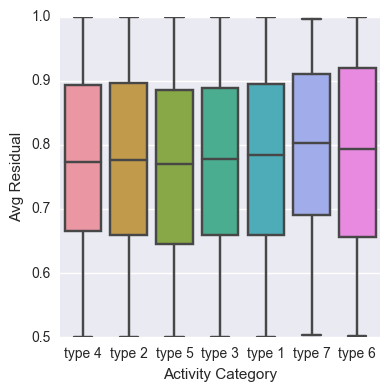

In [69]:
ax = sns.factorplot(x='activity_category',y='residual',data=df.loc[df['residual']>0],kind='box')
ax.set(xlabel='Activity Category',ylabel='Avg Residual')

In [38]:
N = X_val.shape[0]
e = N//2

In [92]:
predictions = np.zeros((error_feature[e:].shape[0],1))
ba = 1-np.sum(error_feature[e:])*1.0/error_feature[e:].shape[0]
predictions[:] = 1-ba
rmse = RMSE(error_feature[e:], predictions)
r2 = r2_score(error_feature[e:], predictions)
print 'Baseline accuracy: {} RMSE: {} R^2: {}'.format(ba,rmse,r2)

Baseline accuracy: 0.906913029627 RMSE: 6.20872003213e-18 R^2: 0.0


In [49]:
error_feature = np.zeros((X_val.shape[0],1))
error_feature[bads[0]] = 1
dt = DecisionTreeClassifier(max_depth=3,criterion='entropy')
dt.fit(X_val[:e], error_feature[:e])
tree.export_graphviz(dt,
     out_file='resid_tree.dot')

In [50]:
!dot -Tpng resid_tree.dot -o resid_tree.png 

<h3>Decision tree for residuals</h3>
<img src='resid_tree.png' align='left' height='100%' width='500px'/>

In [86]:
predictions = dt.predict(X_val[e:])
a = accuracy_score(error_feature[e:], predictions)
print 'DT accuracy change: {}'.format(a-b)

DT accuracy change: 0.0


In [ ]:
lr = LogisticRegression(C=100.0)
lr.fit(X_val[:e], error_feature[:e].ravel())

In [103]:
predictions = lr.predict(X_val[e:])
a = accuracy_score(error_feature[e:], predictions)
print 'LR accuracy change: {}'.format(a-b)

LR accuracy change: -0.00240750011378


In [26]:
lr = LinearRegression()
lr.fit(X_val[:e], error_feature[:e])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [96]:
predictions = lr.predict(X_val[e:])
r2 = r2_score(error_feature[e:], predictions)
rmse = np.sqrt(np.mean(error_feature[e:]-predictions)**2)
print 'R^2 of residual model: {}'.format(r2)
print 'RMSE: {}'.format(rmse)

R^2 of residual model: 0.0842687209448
RMSE: 0.00176002894453


#### Submission

In [ ]:
c     = 1e2
tol   = 1e-4
iters = 200
lr = LogisticRegression(C=c, max_iter=iters, tol=tol, n_jobs=CPUS)
lr.fit(X, Y)
predictions = lr.predict_proba(X_test)

In [ ]:
submission = pd.DataFrame(np.vstack((IDs, 
                                     predictions[:,1])).T,
                          columns=['activity_id','outcome'])
submission.to_csv('submission.csv', index=False)

##### Use already-known predictions via forums

In [156]:
def add_leak_data(submission, loc='./Data/leak.csv.gz'):
    leak = pd.read_csv(loc)
    leak.columns = ['activity_id','leak_outcome']
    leak = leak.loc[(leak['leak_outcome']==1.0) | (leak['leak_outcome']==0.0),:]
    leak_submission = pd.merge(submission, leak, how='left', on='activity_id')
    nonleak = np.isnan(leak_submission['leak_outcome'])
    leak_submission.loc[nonleak,'leak_outcome'] = leak_submission.loc[nonleak, 'outcome']
    del leak_submission['outcome']
    leak_submission.columns = ['activity_id','outcome']
    return leak_submission

# leak_submission = add_leak_data(submission)
# leak_submission.to_csv('leak_submission.csv', index=False)

!gzip submission.csv
!s3put -bbrandonshurick -p/home/ubuntu/ -gpublic-read submission.csv.gz 

## Decision tree Logistic Regression

In [196]:
dt = DecisionTreeClassifier(criterion='entropy',  max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [206]:
tree.export_graphviz(dt,
     out_file='tree.dot')

In [207]:
!dot -Tpng tree.dot -o tree.png 

<h3>Decision tree </h3>
<img src='tree.png' align='left' height='100%' width='500px'/>

In [225]:
# all thresholds are 0.5
threshold = 0.5

# first level
feature1 = 11566
f1_l = (X_train[:,feature1]<=threshold).A.ravel()
f1_r = (X_train[:,feature1]>threshold).A.ravel()

# second level
feature2 = 19318
f2_l = f1_l & (X_train[:,feature2]<=threshold).A.ravel()
f2_r = f1_r & (X_train[:,feature2]>threshold).A.ravel()

# third level 
feature3 = 6755
f3_l = f2_l & (X_train[:,feature3]<=threshold).A.ravel()
f3_r = f2_l & (X_train[:,feature3]>threshold).A.ravel()

# models
model_f1_r = [ 1.0, 0.0 ] # val outcome is always zero 
model_f2_r = [ 1.0, 0.0 ] # val outcome is nearly always zero 
model_f3_l = LogisticRegression(C=0.1, max_iter=200, tol=1e-4).fit(X_train[f3_l],y_train[f3_l])
model_f3_r = LogisticRegression(C=0.1, max_iter=200, tol=1e-4).fit(X_train[f3_r],y_train[f3_r])

In [226]:
# first level
f1_l = (X_val[:,feature1]<=threshold).A.ravel()
f1_r = (X_val[:,feature1]>threshold).A.ravel()

# second level
f2_l = f1_l & (X_val[:,feature2]<=threshold).A.ravel()
f2_r = f1_r & (X_val[:,feature2]>threshold).A.ravel()

# third level 
f3_l = f2_l & (X_val[:,feature3]<=threshold).A.ravel()
f3_r = f2_l & (X_val[:,feature3]>threshold).A.ravel()

# predict
predictions = np.zeros((y_val.shape[0], 2))
predictions[f1_r] = model_f1_r
predictions[f2_r] = model_f2_r
predictions[f3_l] = model_f3_l.predict_proba(X_val[f3_l])
predictions[f3_r] = model_f3_r.predict_proba(X_val[f3_r])

In [227]:
_ = test_scores(y_val, predictions)

C:100.0 Log-Loss:0.2355023 Accuracy:0.8928751 AUC:0.9630686


<h3>DT Logistic Regression Result Tracker</h3>
<table align="left">
<tr>
    <th>Iter</th>
    <th>C</th>
    <th>Tol</th>
    <th>Depth</th>
    <th>AUC</th>
    <th>Log Loss</th>
    <th>Accuracy</th>
</tr>
<tr>
    <td>200</td>
    <td>1.0</td>
    <td>1e-4</td>
    <td>1</td>
    <td>0.9744524</td>
    <td>0.1952951</td>
    <td>0.9077684</td>
</tr>
<tr>
    <td>200</td>
    <td>10.0</td>
    <td>1e-4</td>
    <td>1</td>
    <td>0.9771368</td>
    <td>0.1897558</td>
    <td>0.9108609</td>
</tr>
<tr>
    <td>200</td>
    <td>10.0</td>
    <td>1e-4</td>
    <td>2</td>
    <td>0.9775437</td>
    <td>0.1890088</td>
    <td>0.9107107</td>
</tr>
<tr>
    <td>200</td>
    <td>100.0</td>
    <td>1e-4</td>
    <td>3</td>
    <td>0.9630686</td>
    <td>0.2355023</td>
    <td>0.8928751</td>
</tr>

</table>